Mount Google Drive + Import tensorflow, numpy, and matplot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load dataset and specifications

In [ ]:
# Define the path to your dataset in Google Drive
data_dir = '/content/drive/MyDrive/dataset/subdir'

# Set image parameters
IMG_HEIGHT = 160
IMG_WIDTH = 160
BATCH_SIZE = 32


Create Training + Validation Dataset

In [ ]:
# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, #20% is used for validation
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)
print(len(class_names))



Found 1728 files belonging to 26 classes.
Using 1383 files for training.
Found 1728 files belonging to 26 classes.
Using 345 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
26


Performance Optimization -

cache() keeps data in RAM after first load → faster.

prefetch() overlaps training & data loading → faster.

shuffle() prevents the model from seeing letters in order

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Build the Model

GlobalAveragePooling2D — compresses features into a vector.

Dense(128, relu) — learns ASL-specific patterns.

Dropout(0.2) — prevents overfitting.

Dense(26, softmax) — outputs probabilities for A–Z.

In [ ]:
# Import necessary layers from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# Define the number of classes
num_classes = len(class_names)

# Load the pre-trained MobileNetV2 model
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) # Define the shape set earlier
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(), # Reduces feature maps to a vector
    Dense(128, activation='relu'),            # A hidden layer
    Dropout(0.2),                             # Helps prevent overfitting
    Dense(num_classes, activation='softmax')  # Output layer for A, B, C...
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', # Good for integer labels
              metrics=['accuracy'])

# Prints a summary of the model structure
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,425,306 (9.25 MB)

 Trainable params: 167,322 (653.60 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Image Augmentation -

This object creates artificial variations of images so the model sees more types of the same hand signs.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=0.25,
    shear_range=15,
    brightness_range=[0.5, 1.5],
    channel_shift_range=30,
    horizontal_flip=False,  # DO NOT flip in ASL
    fill_mode='nearest',
    validation_split=0.2,
    rescale=1/255.
)


train_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 1391 images belonging to 26 classes.
Found 337 images belonging to 26 classes.


Early Stopping in Training - This creates a callback that automatically stops training when the model stops improving.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


Train the Model - Tracks accuracy & loss for both training and validation.

In [ ]:
from tensorflow.keras.optimizers import Adam

# Recompile the model with the correct loss function
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set the number of training sessions (epochs)
EPOCHS = 75

# Start the training process
history = model.fit(
    train_ds,
    epochs=75,
    validation_data=val_ds,
    callbacks=[early_stop]
)

Epoch 1/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 554s 12s/step - accuracy: 0.0871 - loss: 3.4005 - val_accuracy: 0.0920 - val_loss: 3.2454
Epoch 2/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 370ms/step - accuracy: 0.0981 - loss: 3.1649 - val_accuracy: 0.1098 - val_loss: 3.0907
Epoch 3/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step - accuracy: 0.1470 - loss: 3.0315 - val_accuracy: 0.1484 - val_loss: 3.0448
Epoch 4/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 370ms/step - accuracy: 0.1450 - loss: 2.9823 - val_accuracy: 0.1573 - val_loss: 2.9761
Epoch 5/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 366ms/step - accuracy: 0.1964 - loss: 2.8671 - val_accuracy: 0.1810 - val_loss: 2.9012
Epoch 6/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 356ms/step - accuracy: 0.2190 - loss: 2.7890 - val_accuracy: 0.2196 - val_loss: 2.7754
Epoch 7/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 366ms/step - accuracy: 0.2709 - loss: 2.6475 - val_accuracy: 0.2315 - val_loss: 2.6904
Epoch 8/75
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step - accuracy: 0.2802 - loss: 2.5578 - val_accur

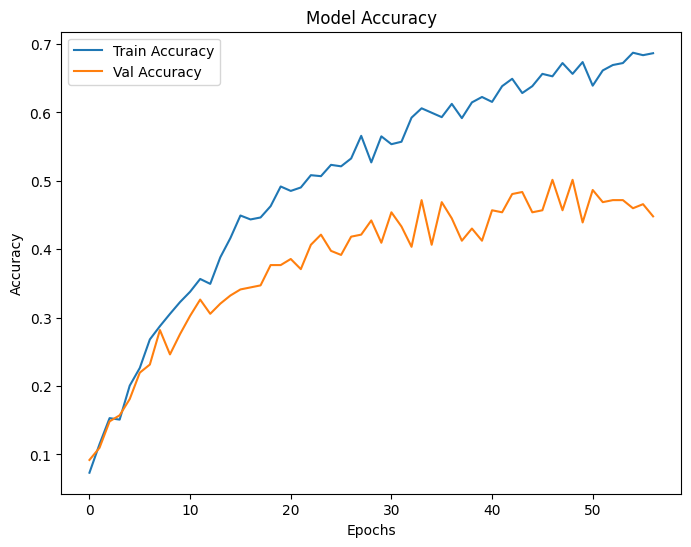

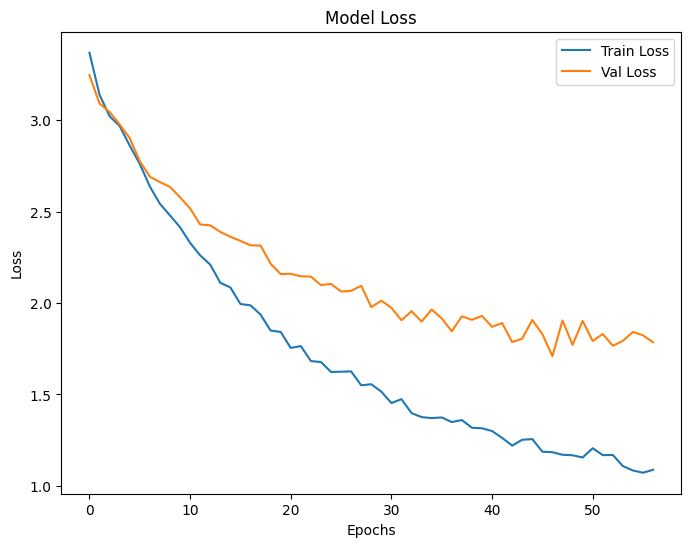

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Save Model + Convert to TFLite

In [ ]:
import os
import tensorflow as tf

# Define where to save the model in your Google Drive
save_path_dir = '/content/drive/MyDrive/ASL_MODEL'
os.makedirs(save_path_dir, exist_ok=True) # Create the directory if it doesn't exist

# Use the Keras .save() method directly on the model object
keras_model_path = os.path.join(save_path_dir, 'my_asl_model.h5')
model.save(keras_model_path)
print(f"Keras model successfully saved to: {keras_model_path}")


# Convert the Keras model (now saved to disk) to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Define the path and filename for the TFLite model file
tflite_model_path = os.path.join(save_path_dir, 'sign_model.tflite')

# Save the TFLite model file to your Google Drive
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model saved in TFLite format to: {tflite_model_path}")

# Also save the label map (class names)
with open(os.path.join(save_path_dir, 'labelmap.txt'), 'w') as f:
    for name in class_names:
        f.write(f"{name}\n")